## Resources
https://www.quantinsti.com/blog/artificial-neural-network-python-using-keras-predicting-stock-price-movement?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html



In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

random.seed(42)

def load_data(fpath, dropna=True):
    df = pd.read_csv(fpath)
    if dropna:
        df = df.dropna()
    df = df[['Date', 'Close']]
    df['Month'] = df['Date'].map(lambda x: int(x.split('/')[0]))
    df['Day'] = df['Date'].map(lambda x: int(x.split('/')[1]))

    df['Month_sin'] = np.sin((df.Month-1)*(2*np.pi/12))
    df['Month_cos'] = np.cos((df.Month-1)*(2*np.pi/12))

    df['Day_sin'] = np.sin((df.Day-1)*(2*np.pi/31))
    df['Day_cos'] = np.cos((df.Day-1)*(2*np.pi/31))
    return df

def add_features(df):
    df['3day MA'] = df['Close'].rolling(window = 3).mean()
    df['10day MA'] = df['Close'].rolling(window = 10).mean()
    df['30day MA'] = df['Close'].rolling(window = 30).mean()
    df['Std_dev']= df['Close'].rolling(5).std()
    
    df = df.dropna()
    return df


In [32]:
company_files = ['BAYZF.csv', 'HON.csv', 'MMM.csv', 'SYF.csv']
fpath = './Data Given/' + company_files[3]
df = load_data(fpath)
df = add_features(df)
print(df.head(5))

         Date      Close  Month  Day  Month_sin  Month_cos   Day_sin  \
29  9/11/2014  24.650000      9   11  -0.866025       -0.5  0.897805   
30  9/12/2014  24.500000      9   12  -0.866025       -0.5  0.790776   
31  9/15/2014  24.150000      9   15  -0.866025       -0.5  0.299363   
32  9/16/2014  24.309999      9   16  -0.866025       -0.5  0.101168   
33  9/17/2014  24.549999      9   17  -0.866025       -0.5 -0.101168   

     Day_cos    3day MA   10day MA   30day MA   Std_dev  
29 -0.440394  24.796667  25.376001  24.296667  0.456234  
30 -0.612106  24.616667  25.257001  24.346667  0.204402  
31 -0.954139  24.433333  25.093001  24.385000  0.323373  
32 -0.994869  24.320000  24.945000  24.428667  0.231236  
33 -0.994869  24.336666  24.821000  24.480334  0.200300  


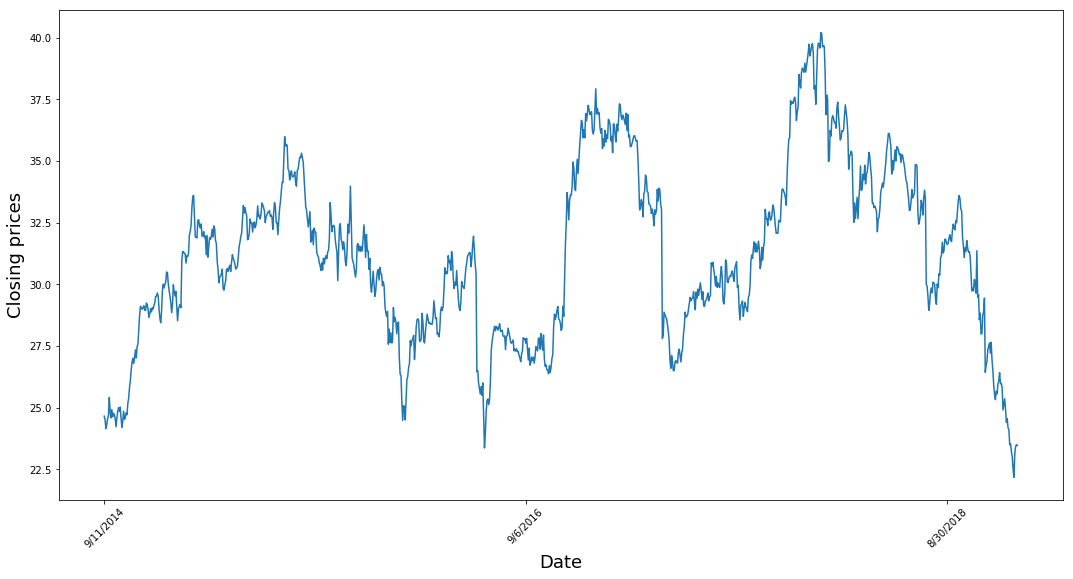

In [33]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), df['Close'])
plt.xticks(range(0,df.shape[0],500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing prices', fontsize=18)
plt.show()

In [34]:
input_features = df[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']].loc[:].values

split_idx = int(0.9*len(input_features))
train_data = input_features[:split_idx]
test_data = input_features[split_idx:]

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_data)
test_set_scaled = sc.transform(test_data)


In [35]:
def get_X_Y_train(training_set_scaled, chunk_size=45):
    X_train = []
    Y_train = []

    for i in range(chunk_size, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-chunk_size:i])
        Y_train.append(training_set_scaled[i, 0])

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    return X_train, Y_train


In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def fit_model(X_train, Y_train, epochs=3):
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 50, return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.4))

    model.add(Dense(units=1))

    # Could experiment using root_mean_squared error
    model.compile(optimizer='adam', loss="mean_squared_error")

    model.fit(X_train, Y_train, epochs=epochs, batch_size=32)
    return model
          

In [37]:
X_train, Y_train = get_X_Y_train(training_set_scaled)
model = fit_model(X_train, Y_train)

Epoch 1/3
930/930 [==============================] - 16s 17ms/step - loss: 0.0502
Epoch 2/3
930/930 [==============================] - 10s 11ms/step - loss: 0.0207
Epoch 3/3
930/930 [==============================] - 11s 12ms/step - loss: 0.0159


In [38]:
def predict_stock_prices(total_data, chunk_size, num_days, num_trailing_blanks, sc, model):
    predicted_stock_prices = []

    for day in range(num_days):
        curr_idx = len(total_data) - num_trailing_blanks + day

        start_idx = len(total_data) - num_trailing_blanks - chunk_size + day
        end_idx = start_idx+chunk_size
        inputs = total_data[start_idx:end_idx]
        X_test = []
        X_test.append(inputs)

        X_test = np.array(X_test)
        predicted_stock_price = model.predict(X_test)
        
        total_data[curr_idx][0] = predicted_stock_price
        total_data[curr_idx][5] = total_data[curr_idx-2:curr_idx+1, 0].mean()
        total_data[curr_idx][6] = total_data[curr_idx-9:curr_idx+1, 0].mean()
        total_data[curr_idx][7] = total_data[curr_idx-29:curr_idx+1, 0].mean()
        total_data[curr_idx][8] = total_data[curr_idx-4:curr_idx+1, 0].std()


        predicted_stock_price = sc.inverse_transform(total_data[curr_idx].reshape(1, -1))[0][0]
        predicted_stock_prices.append(predicted_stock_price)
        
    return predicted_stock_prices

In [39]:
num_days = 50
chunk_size = 45
total_data = np.concatenate((training_set_scaled, test_set_scaled))
predicted_stock_prices = predict_stock_prices(total_data, chunk_size, num_days, len(test_set_scaled), sc=sc, model=model)

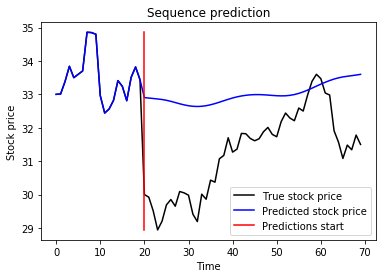

[32.90318690438783, 32.889575109505174, 32.87585384176469, 32.86142953732252, 32.845522829777956, 32.82173206779313, 32.790282223112584, 32.754256613842244, 32.71786944283962, 32.6850577156341, 32.65900719282245, 32.64225483255958, 32.63643067565524, 32.642499891067025, 32.66008183463788, 32.68779152406549, 32.72359517460573, 32.76504019250786, 32.80885343975651, 32.851848151416775, 32.891209167667505, 32.924903708102704, 32.95172154525733, 32.97188162484705, 32.98528050004291, 32.99201358296871, 32.99246151778149, 32.98739161882424, 32.978266202436444, 32.967624235449314, 32.95861130493378, 32.95421431253385, 32.957351864899636, 32.970272675138354, 32.994028285288096, 33.02877235908508, 33.07369037829351, 33.12686707007038, 33.18527234623146, 33.245775684777975, 33.30550769162893, 33.36207000729346, 33.41338365181088, 33.4578798489983, 33.49440762734127, 33.522309145354626, 33.541510082015634, 33.55957912958693, 33.57846269539404, 33.59909782692647]


In [40]:
actual_line = np.concatenate((train_data[-20:, 0], test_data[:num_days, 0]))
predicted_line = np.concatenate((train_data[-20:, 0], predicted_stock_prices))

miny = min(np.min(actual_line), np.min(predicted_line))
maxy = max(np.max(actual_line), np.max(predicted_line))

plt.plot(actual_line, color='black', label='True stock price')
plt.plot(predicted_line, color='blue', label='Predicted stock price')
plt.plot((20, 20), (miny, maxy), 'k-', color='red', label='Predictions start')
plt.title("Sequence prediction")
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()
print(predicted_stock_prices)

In [41]:
# company_files = ['BAYZF.csv', 'HON.csv', 'MMM.csv', 'SYF.csv']
# fpath = './Data Given/' + company_files[1]
df = load_data(fpath)
df = add_features(df)

input_data = df[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']].loc[:].values

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(input_data)

chunk_size=45
X_train, Y_train = get_X_Y_train(training_set_scaled, chunk_size=chunk_size)
model = fit_model(X_train, Y_train, epochs=2)



Epoch 1/2
1039/1039 [==============================] - 16s 15ms/step - loss: 0.0445
Epoch 2/2
1039/1039 [==============================] - 11s 10ms/step - loss: 0.0180


In [42]:
df_predict = load_data('./Data Given/submission_template.csv', dropna=False)
df_predict['Close'] = 0.
df_predict['3day MA'] = 0.
df_predict['10day MA'] = 0.
df_predict['30day MA'] = 0.
df_predict['Std_dev'] = 0.

predict_data = df_predict[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']]
predict_data_scaled = sc.transform(predict_data)
# predict_data_scaled = predict_data_scaled.loc[:].values

total_data = np.concatenate((training_set_scaled, predict_data_scaled))

num_days = len(df_predict)
predicted_stock_prices = predict_stock_prices(total_data, chunk_size, num_days, len(predict_data_scaled), sc=sc, model=model)
print(predicted_stock_prices)


# df.to_csv('Team50_Undergrad.csv')

[25.006935846903744, 24.833002689087692, 24.721911403341295, 24.677182416219594, 24.69439745261121, 24.765907057869676, 24.88221554265243, 25.032722917656006, 25.207189139450268, 25.39465050942135, 25.585180424683035, 25.770199324000554, 25.943237052612663, 26.099936894485655, 26.23422842563771, 26.341377511061133, 26.419779582482636, 26.470901036271933, 26.499345631224188, 26.512736477926435, 26.518426257131072, 26.522766306514935, 26.52824694614567, 26.541190212654413, 26.56694421892391, 26.60886595081392, 26.668458901430906, 26.745487318324596, 26.83753991360566, 26.941920991069615, 27.05524023155701, 27.173637961543324]


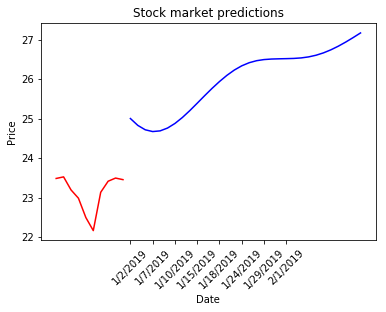

In [43]:

ys = list(input_data[-10:, 0])
xs = range(len(ys))
plt.plot(xs, ys, color='red', label='Real stock prices from last year')

plt.plot(range(10, 10+len(predicted_stock_prices)), predicted_stock_prices, color='blue', label='Predictions')

plt.xticks(range(10, len(df_predict), 3), df_predict['Date'].loc[::3], rotation=45)
plt.title("Stock market predictions")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()